In [1]:
from itertools import product
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

### Notes:
- Based on boxplots it seems that big jump from 2020 to 2021 and 2022 seasons
- Starting in 2021, the number of athletes recorded is 50 instead of 75 (maybe we should only keep top 50 for consistency in other years)
- 2020 may be a transition year for supershoes, could throw it out because they are not fully adopted, plus covid/masking while running makes it a weird year.
- Here I assign ordinal values to class year, but maybe we should use dummy vars instead. Same for yearOrdinal
 

In [2]:
events = ["mile", "3000m", "5000m"]
gender = ["f", "m"]
years = list(np.arange(2016, 2023, 1))

combinations = list(product(events, gender, years))

# preprocess and concatenate data from all genders, events, and years
for event, gender, year in combinations:
    temp = pd.read_csv(f"data/{year}_{year+1}_{event}_{gender}.csv")
    # one-hot encode gender
    temp["gender"] = 0 if gender == "f" else 1

    # infer whether supershoes were worn based on year
    # (Nike Dragonfly released in Aug 2020)
    temp["supershoes"] = 1 if year >= 2021 else 0

    # maintain ordinal value for year (may need to scale later)
    temp["year"] = int(year)
    temp["yearOrdinal"] = int(year-2015)

    # add event column
    temp["event"] = event

    if year == 2016 and gender == "f" and event == "mile":
        data = temp
    else:
        data = pd.concat([data, temp], sort=False)

# Assign ordinal values to class year?
# fill NAN values with another class. 5 = other. 
# Typically this happens because of a redshirt season or later injury
# only happens for 6 people in whole dataset
data = data.rename(columns={"Year": "ClassYear"})
data["ClassYear"] = data["ClassYear"].str[0:2].map({"FR": 1, "SO": 2, "JR": 3, "SR": 4})
data["ClassYear"] = data["ClassYear"].fillna(5)

data["dummy"] = data["event"]
# add dummy variables for event
data = pd.get_dummies(data, columns=["dummy"])

In [9]:
data.describe()

,Rank,ClassYear,Time_seconds,gender,supershoes,year,yearOrdinal
count,2850.000000,2850.000000,2850.000000,2850.000000,2850.000000,2850.000000,2850.000000
mean,35.347719,2.907018,556.528189,0.500000,0.210526,2018.736842,3.736842
std,20.968063,1.018667,266.347979,0.500088,0.407754,1.915431,1.915431
min,1.000000,1.000000,230.390000,0.000000,0.000000,2016.000000,1.000000
25%,17.000000,2.000000,278.912500,0.000000,0.000000,2017.000000,2.000000
50%,34.000000,3.000000,501.380000,0.500000,0.000000,2019.000000,4.000000
75%,52.000000,4.000000,832.245000,1.000000,0.000000,2020.000000,5.000000
max,75.000000,5.000000,1004.970000,1.000000,1.000000,2022.000000,7.000000


In [3]:
data.head()

,Rank,Athlete,ClassYear,Team,Time,Meet,Meet_Date,Time_seconds,gender,supershoes,year,yearOrdinal,event,dummy_3000m,dummy_5000m,dummy_mile
0,1,"Edwards, Kaela",4.0,Oklahoma State,4:28.75,110th NYRR Millrose Games,"Feb 11, 2017",268.75,0,0,2016,1,mile,False,False,True
1,2,"Purrier, Elinor",3.0,New Hampshire,4:29.44,110th NYRR Millrose Games,"Feb 11, 2017",269.44,0,0,2016,1,mile,False,False,True
2,3,"Rivers, Danae",1.0,Penn State,4:32.55,2017 Husky Classic,"Feb 10, 2017",272.55,0,0,2016,1,mile,False,False,True
3,4,"Jones, Dani",2.0,Colorado,4:32.68\n@,Colorado Open,"Feb 2, 2017",272.68,0,0,2016,1,mile,False,False,True
4,5,"Cleirigh Buttner, Siofra",3.0,Villanova,4:33.16,Fastrack National Invite,"Feb 10, 2017",273.16,0,0,2016,1,mile,False,False,True


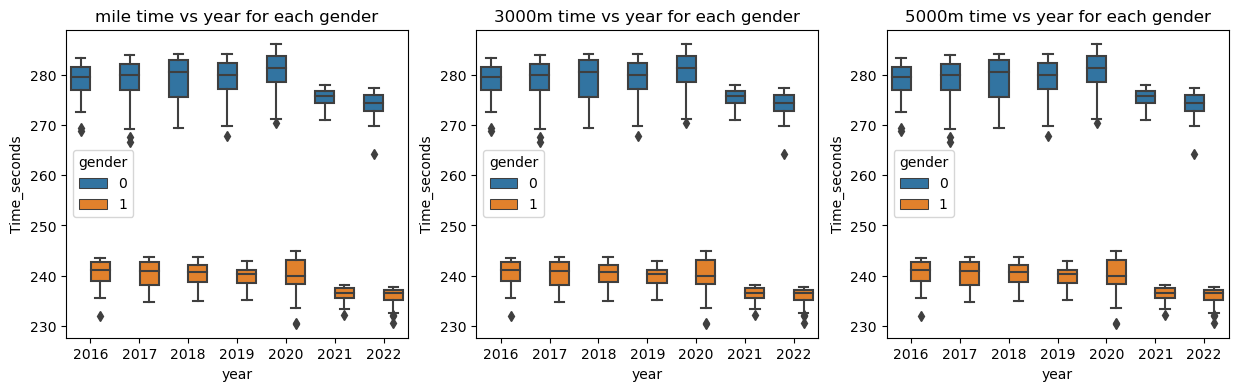

In [4]:
# Make boxplots for each year/gender and event
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
for event, ax in zip(events, axs):
    temp = data[(data["event"] == "mile")]
    sns.boxplot(x="year", y="Time_seconds", ax=ax, data=temp, hue="gender").set(
        title=f"{event} time vs year for each gender"
    )

In [5]:
# helper function to build eqn string and save supershoe coefficients
def build_eqn(model, cols, supershoe_coefs=[]):
    eqn = f"{np.round(model.intercept_, 3)} + "
    for coef, col in zip(model.coef_, cols):
        if col == "supershoes": supershoe_coefs.append(coef)
        eqn += f"({np.round(coef, 3)})*{col} + "
    return eqn[:-2], supershoe_coefs

# Linear Regression
# only fit on relevant columns for x data
print(f"Linear fit results for all predictors:")
temp = data
x_cols = [
    "dummy_5000m",
    "dummy_3000m",
    "dummy_mile", 
    "gender",
    "supershoes",
    "yearOrdinal",
    "Rank",
    "ClassYear",
]
x = temp[x_cols]
y = temp["Time_seconds"]
# create linear regression model
model = LinearRegression().fit(x, y)
print(f"R^2: {model.score(x, y)}")
eqn, _ = build_eqn(model, x_cols)
print(f"Equation: Time_seconds = {eqn}")

Linear fit results for all predictors:
R^2: 0.9941212519054592
Equation: Time_seconds = 586.879 + (340.273)*dummy_5000m + (-42.721)*dummy_3000m + (-297.553)*dummy_mile + (-82.417)*gender + (-10.031)*supershoes + (0.435)*yearOrdinal + (0.366)*Rank + (-0.553)*ClassYear 


In [6]:

# Now we split out the data by event and fit a linear 
# regression model for each event separately
supershoe_coefs = []
for event in events:
    print(f"\nEvent: {event} linear fit results:")
    temp = data[(data["event"] == event)]
    x_cols = [
        "gender",
        "supershoes",
        "yearOrdinal",
        "Rank",
        "ClassYear",
    ]
    x = temp[x_cols]
    y = temp["Time_seconds"]
    # create linear regression model
    model = LinearRegression().fit(x, y)
    print(f"R^2: {model.score(x, y)}")
    eqn, supershoe_coefs = build_eqn(model, x_cols, supershoe_coefs)
    print(f"Equation: Time_seconds = {eqn}")


Event: mile linear fit results:
R^2: 0.996384214148695
Equation: Time_seconds = 274.162 + (-39.043)*gender + (-3.136)*supershoes + (0.095)*yearOrdinal + (0.136)*Rank + (-0.061)*ClassYear 

Event: 3000m linear fit results:
R^2: 0.9940553725223424
Equation: Time_seconds = 541.246 + (-75.442)*gender + (-9.139)*supershoes + (0.301)*yearOrdinal + (0.32)*Rank + (-0.08)*ClassYear 

Event: 5000m linear fit results:
R^2: 0.9910689213213725
Equation: Time_seconds = 941.113 + (-132.741)*gender + (-17.582)*supershoes + (0.928)*yearOrdinal + (0.648)*Rank + (-0.216)*ClassYear 


Text(0.5, 1.0, 'Supershoe effect for each event')

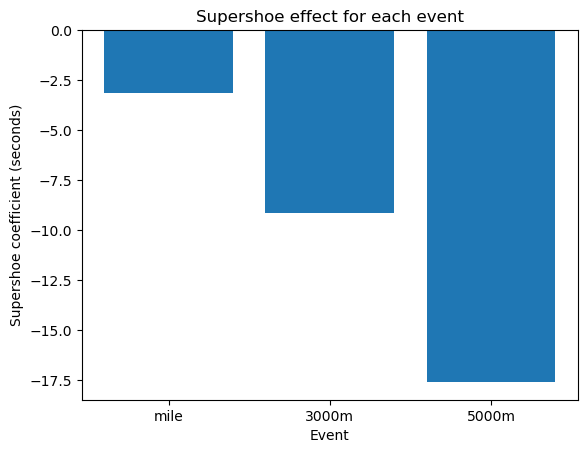

In [7]:
# Plot bar plot of effect as measured by coefficients
plt.bar(events, supershoe_coefs)
plt.ylabel("Supershoe coefficient (seconds)")
plt.xlabel("Event")
plt.title(f"Supershoe effect for each event")


Event: mile linear fit results:
R^2: 0.9146676083919167
Equation for gender 0: Time_seconds = 272.465 + (-3.82)*supershoes + (0.326)*yearOrdinal + (0.165)*Rank + (-0.071)*ClassYear 
R^2: 0.9331566909970163
Equation for gender 1: Time_seconds = 236.745 + (-2.452)*supershoes + (-0.134)*yearOrdinal + (0.108)*Rank + (-0.028)*ClassYear 

Event: 3000m linear fit results:
R^2: 0.9088092931258234
Equation for gender 0: Time_seconds = 538.302 + (-10.123)*supershoes + (0.535)*yearOrdinal + (0.397)*Rank + (-0.232)*ClassYear 
R^2: 0.940954610811211
Equation for gender 1: Time_seconds = 469.144 + (-8.182)*supershoes + (0.066)*yearOrdinal + (0.243)*Rank + (-0.058)*ClassYear 

Event: 5000m linear fit results:
R^2: 0.8870439782792399
Equation for gender 0: Time_seconds = 929.818 + (-21.359)*supershoes + (2.884)*yearOrdinal + (0.796)*Rank + (-0.369)*ClassYear 
R^2: 0.9603711795223497
Equation for gender 1: Time_seconds = 820.47 + (-13.87)*supershoes + (-1.023)*yearOrdinal + (0.499)*Rank + (-0.325)*Cla

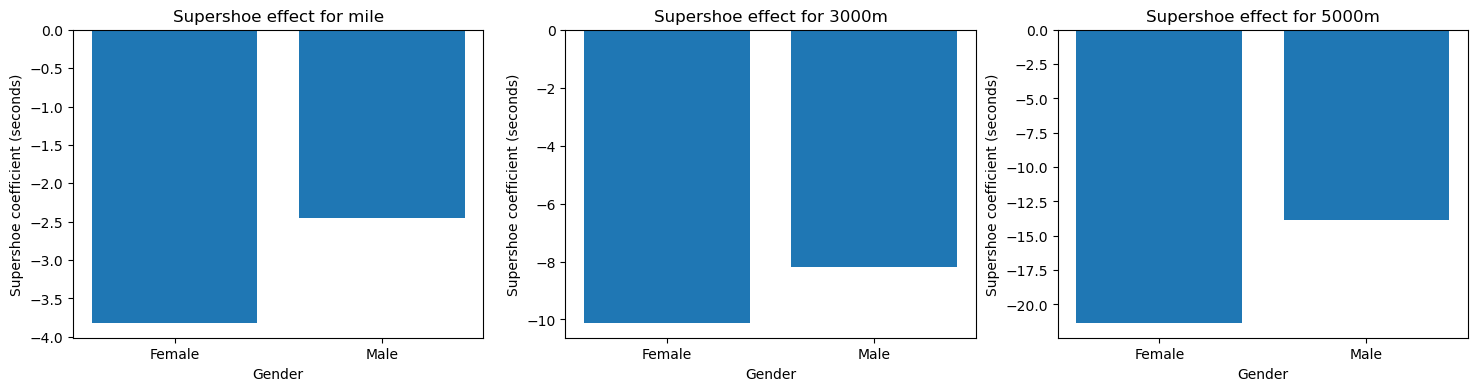

In [8]:
# Here we separate the equations by gender and event to see 
# if there are differences in the effect of supershoes across 
# events or genders
fig, axs = plt.subplots(1, 3, figsize=(18, 4))
for event, ax in zip(events, axs):
    print(f"\nEvent: {event} linear fit results:")
    supershoe_coefs = []
    for gender in [0, 1]:
        temp = data[(data["event"] == event) & (data["gender"] == gender)]
        x_cols = [
            "supershoes",
            "yearOrdinal",
            "Rank",
            "ClassYear",
        ]
        x = temp[x_cols]
        y = temp["Time_seconds"]
        # create linear regression model
        model = LinearRegression().fit(x, y)
        print(f"R^2: {model.score(x, y)}")
        eqn, supershoe_coefs = build_eqn(model, x_cols, supershoe_coefs)
        print(f"Equation for gender {gender}: Time_seconds = {eqn}")
    ax.bar(["Female", "Male"], supershoe_coefs)
    ax.set_ylabel("Supershoe coefficient (seconds)")
    ax.set_xlabel("Gender")
    ax.set_title(f"Supershoe effect for {event}")